# Orion Tulog

This is a tutorial for anomaly detection using Orion. Orion is a `python` package for time series anoamly detection. It provides a suite of both statistical and machine learning models that enable efficient anomaly detection.

In this tutorial, we will learn how to set up Orion, train a machine learning model, and perform anomaly detection. We will delve into each part seperately and then run the evaluation pipeline from beginning to end in order to compare multiple models against each other.

In [1]:
# general imports 

import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

from utils import plot, plot_ts

## Data Loading
There is a collection of data already available in Orion, to load them, we use the `load_signal` function and pass the name of the signal we wish to obtain. Similarly, since this data is labeled, we use the `load_anomalies` function to get the corresponding anomaly of the signal

In [2]:
from orion.data import load_signal, load_anomalies

In [3]:
signal = 'nyc_taxi'

# load signal
df = load_signal(signal)

# load ground truth anomalies
known_anomalies = load_anomalies(signal)

df.head(5)

,timestamp,value
0,1404165600,10844.0
1,1404167400,8127.0
2,1404169200,6210.0
3,1404171000,4656.0
4,1404172800,3820.0


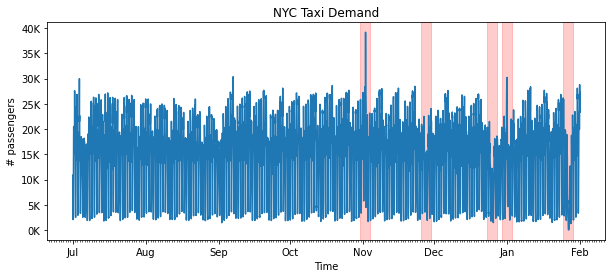

In [4]:
# plotting functions that will be hidden

plot(df, known_anomalies)

## Prepare Data

### A. data frequency
Adjust signal spacing to be of equal width across all times. There are two important parameters in this process:
- interval: an interger that refers to the time span to compute aggregation of.
- method: what aggregation method should be used to compute the value, by default this set to the mean.

In addition to, passing the array of values and which column holds the values we wish to alter the frequency of.

In [5]:
def time_segments_aggregate(X, interval, time_column, method=['mean']):
    """Aggregate values over given time span.
    Args:
        X (ndarray or pandas.DataFrame):
            N-dimensional sequence of values.
        interval (int):
            Integer denoting time span to compute aggregation of.
        time_column (int):
            Column of X that contains time values.
        method (str or list):
            Optional. String describing aggregation method or list of strings describing multiple
            aggregation methods. If not given, `mean` is used.
    Returns:
        ndarray, ndarray:
            * Sequence of aggregated values, one column for each aggregation method.
            * Sequence of index values (first index of each aggregated segment).
    """
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)

    X = X.sort_values(time_column).set_index(time_column)

    if isinstance(method, str):
        method = [method]

    start_ts = X.index.values[0]
    max_ts = X.index.values[-1]

    values = list()
    index = list()
    while start_ts <= max_ts:
        end_ts = start_ts + interval
        subset = X.loc[start_ts:end_ts - 1]
        aggregated = [
            getattr(subset, agg)(skipna=True).values
            for agg in method
        ]
        values.append(np.concatenate(aggregated))
        index.append(start_ts)
        start_ts = end_ts

    return np.asarray(values), np.asarray(index)

X, index = time_segments_aggregate(df, interval=3600, time_column='timestamp')

If we go back to the source of the NYC Taxi data, we find that it records a value each 30 minutes. In the timestamp world, this is equivalent to 1800 seconds, therefore we set the interval to be `1800`. We also opt for the default aggregation method which is taking the `mean` value of each interval.

Technically speaking, in our example the data is perfectly spaced, so we can skip this preprocessing step. However, that is not always the case and so we include it as a preprocessing primitive in the general pipeline as you will see later on.

### B. data imputation

impute missing values that appear within the signal using scikit-learn's `SimpleImputer` which fills missing values by the mean value.

In [6]:
imp = SimpleImputer()
X = imp.fit_transform(X)

### C. data normalization 
normalize the data between a specific range, we use scikit-learn's `MinMaxScaler` to scale data between [-1, 1].

In [7]:
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

Notice how the y-axis changed after normalizing the data between [-1, 1]

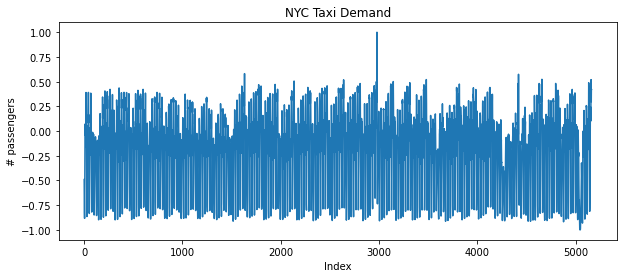

In [8]:
plot_ts(X)

### D. slice the data to rolling window
to prepare the data, we need to transform it into a sequence that is ingestable by the machine learning model. 
We take the signal we're interested in analyzing and we generate training examples. These training examples are mere snapshots of signal at different times.

In order to do that, we adopt the sliding window approach of choosing a window of a pre-specified width and a particular step size. Once that's been decided we divide the signal indo segments, similar to what is depicited in the illustration below.

<img src="images/sliding_window.png" alt="Drawing" style="width: 400px;"/>

We create a `rolling_window_sequence` function that slices the data into parts, each part contains:
- the target value; the value at time t.
- previous observed values, this is determined by the window width.

In [9]:
def rolling_window_sequences(X, index, window_size, target_size, step_size, target_column,
                             drop=None, drop_windows=False):
    """Create rolling window sequences out of time series data.
    The function creates an array of input sequences and an array of target sequences by rolling
    over the input sequence with a specified window.
    Optionally, certain values can be dropped from the sequences.
    Args:
        X (ndarray):
            N-dimensional sequence to iterate over.
        index (ndarray):
            Array containing the index values of X.
        window_size (int):
            Length of the input sequences.
        target_size (int):
            Length of the target sequences.
        step_size (int):
            Indicating the number of steps to move the window forward each round.
        target_column (int):
            Indicating which column of X is the target.
        drop (ndarray or None or str or float or bool):
            Optional. Array of boolean values indicating which values of X are invalid, or value
            indicating which value should be dropped. If not given, `None` is used.
        drop_windows (bool):
            Optional. Indicates whether the dropping functionality should be enabled. If not
            given, `False` is used.
    Returns:
        ndarray, ndarray, ndarray, ndarray:
            * input sequences.
            * target sequences.
            * first index value of each input sequence.
            * first index value of each target sequence.
    """
    out_X = list()
    out_y = list()
    X_index = list()
    y_index = list()
    target = X[:, target_column]

    if drop_windows:
        if hasattr(drop, '__len__') and (not isinstance(drop, str)):
            if len(drop) != len(X):
                raise Exception('Arrays `drop` and `X` must be of the same length.')
        else:
            if isinstance(drop, float) and np.isnan(drop):
                drop = np.isnan(X)
            else:
                drop = X == drop

    start = 0
    max_start = len(X) - window_size - target_size + 1
    while start < max_start:
        end = start + window_size

        if drop_windows:
            drop_window = drop[start:end + target_size]
            to_drop = np.where(drop_window)[0]
            if to_drop.size:
                start += to_drop[-1] + 1
                continue

        out_X.append(X[start:end])
        out_y.append(target[end:end + target_size])
        X_index.append(index[start])
        y_index.append(index[end])
        start = start + step_size

    return np.asarray(out_X), np.asarray(out_y), np.asarray(X_index), np.asarray(y_index)

X, X_index, y, y_index = rolling_window_sequences(X, index, 
                                                  window_size=100, 
                                                  target_size=1, 
                                                  step_size=1,
                                                  target_column=0)

In [10]:
print("Training data input shape: {}".format(X.shape))
print("Training data index shape: {}".format(X_index.shape))
print("Training y shape: {}".format(y.shape))
print("Training y index shape: {}".format(y_index.shape))

Training data input shape: (5061, 100, 1)
Training data index shape: (5061, 1)
Training y shape: (5061,)
Training y index shape: (5061,)
